In [1]:
def create_single_variable_mosaic_plot_pctlabels(ax, data, split_variable, order, color_mapping, title):
           
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels
    
    the_ls = range(0,len(order))
    if split_variable == 'Loading_profile_molly': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]
    if split_variable == 'loading_profile_d50': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.1f}%'
        
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in the_ls:
                text.set_text(label)
                text.set_fontsize(17)
                text.set_color('black')
            counter=counter+1
            
    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')     

In [2]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from scipy import stats
import matplotlib.patches as mpatches

sys.path.insert(1, '../')
# from SeasonalPlot_Functions import *

from MasterPlot_Functions import *
from FormatEvents_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   
cmap = mpl.colormaps['cmr.seaweed']  

In [3]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [4]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [5]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics_new.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)
# df_long = df_long[~df_long['filename'].str.contains("part1", case=False)]

present_all_events=df_long[df_long['Climate']=='Present'].copy()
future_all_events =df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

In [6]:
print(len(present_all_events))
print(len(future_all_events))

1034950
1020443


#### Change data

In [7]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents_new.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents_new.csv")
df_changes_bydurationcat = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydurcategory_new.csv")
df_changes_bydurationcat_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydurcategory_new.csv")

In [57]:
df_changes_bydurationcat2 = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydurcategorysimple_new2.csv")

# Storm characteristics

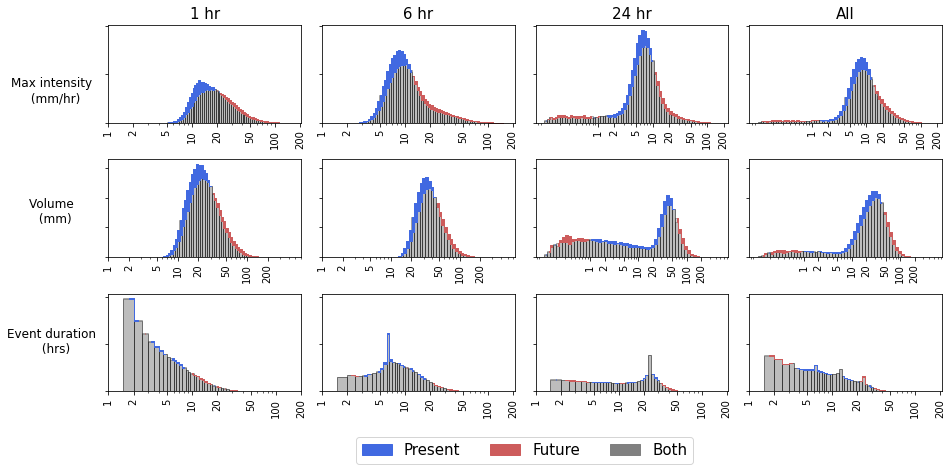

In [9]:
bin_edges_intensity = np.arange(0, 70 + 5, 2)
bin_edges_volume = np.arange(0, 135 + 5, 3)
bin_edges_duration = np.arange(0, 165 + 5,1)

durations = ['1', '6', '24']
alpha = 1
# Create a figure with subplots for different durations
n_categories = len(durations)
n_variables = 3
fig, axs = plt.subplots(n_categories, n_variables+1, figsize=(12, 2 * n_categories),  sharey='row')  

# Call the function for each variable in each duration category
for i, duration in enumerate(durations):
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[0,i], bins=70, alpha=alpha)
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='Volume', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[1,i], bins=60, alpha=alpha)   
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='duration', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[2,i], bins=60, alpha=alpha)       

    axs[0,0].set_title("1 hr", fontsize=15)
    axs[0,1].set_title("6 hr", fontsize=15)
    axs[0,2].set_title("24 hr", fontsize=15)
    axs[0,3].set_title("All", fontsize=15)
    
    # axs[0,3].legend(loc='upper right')

for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_ylabel("")

# Add the all data    
plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', 
    ax=axs[0,3], bins=70, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='Volume', 
     ax=axs[1,3], bins=60, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='duration', 
     ax=axs[2,3], bins=60, alpha=alpha)       

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='grey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.1],
           fontsize=15, ncol=4);

fig.text(-0.045, 0.78, 'Max intensity \n (mm/hr)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.50, 'Volume \n (mm)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.20, 'Event duration \n (hrs)', va='center', ha='center', fontsize=12, rotation='horizontal');

# Adjust layout to prevent overlap
plt.tight_layout()

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

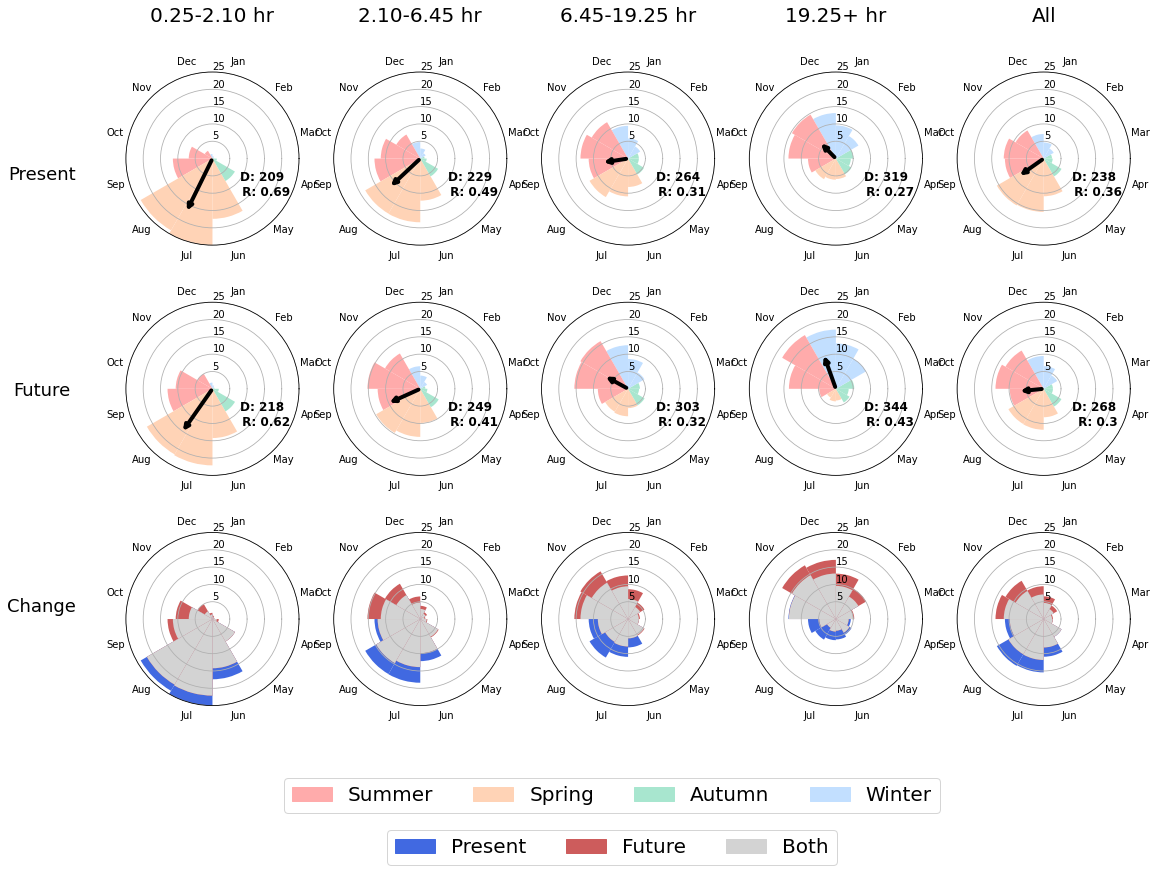

In [10]:
# List of durations and corresponding subplot titles
durations = ['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 5, figsize=(18, 12), subplot_kw={'polar': True})

# Loop through durations, axes, and titles
for ax_num, duration in enumerate(durations):
    this_duration = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, duration, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(present_all_events['theta'])    
plot_polar_months_plot(present_all_events, axes[0, 4], True, "All",25, 'Percentage', D_mean, R)    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, duration in enumerate(durations):
    this_duration = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, duration, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(future_all_events['theta'])    
plot_polar_months_plot(future_all_events, axes[1,4], False, "Present (all)",25,  'Percentage', D_mean, R)    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');

# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, duration in enumerate(durations):
    this_duration_pres = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
    this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present_all_events, future_all_events, axes[2, 4], False, 'All', False, 25) 
fig.text(0.06, 0.25, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Create legend
winter_patch = mpatches.Patch(color='#C2DFFF', label='Winter')
autumn_patch = mpatches.Patch(color='#A8E6CF', label='Autumn')
spring_patch = mpatches.Patch(color='#FFD3B6', label='Spring')
summer_patch = mpatches.Patch(color='#FFABAB', label='Summer')

fig.legend(handles=[summer_patch, spring_patch, autumn_patch, winter_patch], loc = 'lower center', bbox_to_anchor=[0.5, 0],
           fontsize=20, ncol=4);

## Create legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.06],
           fontsize=20, ncol=4);

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Histogram of the days of year for 24h, before 

In [11]:
# # Select data for a specific duration
# this_duration = df_changes_bydurationcat[df_changes_bydurationcat['sampling_duration'] == float(24)].copy()

# fig, axs = plt.subplots(ncols=2, figsize=(14, 3), sharey=True)

# bins=50
# # Plot histograms for both columns with overlap regions
# plot_hist_with_overlap_shading(axs[0], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')

# # Adjust for the second plot
# this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
# this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)

# plot_hist_with_overlap_shading(axs[1], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')
# axs[0].set_ylabel('Number of events', fontsize=15)

# ## Add legend
# present_patch = mpatches.Patch(color='royalblue', label='Present')
# future_patch = mpatches.Patch(color='indianred', label='Future')
# both_patch = mpatches.Patch(color='lightgrey', label='Both')
# fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.15],
#            fontsize=15, ncol=4);

# plt.tight_layout()

### Day of year - present, future, change

In [66]:
D_diffs, D_diffs_dict = find_significance_of_differences(present_all_events, future_all_events, 'D')

In [65]:
D50_diffs, D50_diffs_dict =find_significance_of_differences(present_all_events, future_all_events, 'D50_new')
# b2_diffs, b2_diffs_dict =find_significance_of_differences(present, future, 'B2_percentage')

In [14]:
# plt.scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'], alpha=0.3)
# plt.scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'], alpha=0.3)
# fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True, sharex=True)
# axs[0].scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'])
# axs[1].scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'])

In [15]:
# make_plot_D(df_changes_all, df_changes_byduration, 'D_mean','Blues', D_diffs_dict )

In [16]:
# # Call the function to plot the circular colorbar
# plot_circular_colorbar(colors, month_labels)

In [17]:
# duration=24
# this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num',  'D_mean_present', 'D_mean_future']]
# this_duration["D_mean_present_fixed"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 15 else x)
# this_duration["D_mean_future_fixed"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 15 else x)
    
# print("Present")
# print(this_duration['D_mean_present_fixed'].min())
# print(this_duration['D_mean_present_fixed'].max())

# print("Future")
# print(this_duration['D_mean_future_fixed'].min())
# print(this_duration['D_mean_future_fixed'].max())

In [21]:
# make_plot_D_seasonal_durcats(df_changes_all, df_changes_bydurationcat, 'D_mean', D_diffs_dict )

###  R (how dispersed events are) - present, future change

In [23]:
# make_plot_durcats(df_changes_all, df_changes_bydurationcat, 'R', 'inferno', D_diffs_dict)

# Loading analysis

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'D50_P90', 'RdYlGn') # PiYG #PuBuGn
# make_plot(df_changes_all, df_changes_byduration, 'D50_P10', 'RdYlGn_R') # PiYG #PuBuGn

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'duration_mean', 'RdYlGn', D50_diffs_dict, 3, 17) 

In [25]:
def make_plot_durcats(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 5, figsize=(16, 10))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Using the adjusted `low_lim` and `high_lim`
    for i, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_present]]        
        low_lim = this_duration[variable_present].min()
        high_lim = this_duration[variable_present].max()
        plot_values_on_map(axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present, low_lim, high_lim, cmap)

    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 4], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals, variable_present, low_lim, high_lim, cmap)

    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_future]]
        low_lim = this_duration[variable_future].min()
        high_lim = this_duration[variable_future].max()
        plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)

    # Plot 'All' future values
    scatter = plot_values_on_map(axes[1, 4], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
    cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    # low_lim_diff=-6
    high_lim_diff = -low_lim_diff

    for i, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num',  f'{variable}_diff']]
        
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        scatter = plot_values_on_map(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff',
                                             low_lim_diff, high_lim_diff, 'bwr')
    
    # Plot 'All' differences
    scatter = plot_values_on_map(axes[2, 4], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals,
                                         variable_diff, low_lim_diff, high_lim_diff, 'bwr')    
    
    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.05)
    
    plt.tight_layout()

In [72]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def make_plot_durcats_individualcolorbars_simplecats(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    #fig, axes = plt.subplots(3, 5, figsize=(16, 10))
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))
    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    #################################################
    # Plot Present Data for Each Duration
    #################################################
    positions =[0.16,0.36,0.565,0.765]
    # for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
    for i, duration in enumerate(['<=7hr', '7-16hr','16hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        mean = this_duration[variable_present].mean()
        dynamic_low_lim = this_duration[variable_future].min() + 1
        dynamic_high_lim = this_duration[variable_future].max() - 1
        dynamic_range = dynamic_high_lim - dynamic_low_lim

        # Center dynamically around 50
        low_lim = 50 - (dynamic_range / 2)
        high_lim = 50 + (dynamic_range / 2)

        # Round and enforce symmetry
        low_lim = round(low_lim)
        offset = 50 - low_lim
        high_lim = 50 + offset
        scatter = plot_values_on_map(axes[0, i], this_duration, f'{duration}', tbo_vals, variable_present, low_lim, high_lim, cmap)
        
        # Add the mean value to the top-right corner of the plot
        axes[0, i].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f}",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[0, i].transAxes,  # Use axis coordinates
            fontsize=10, color='black'  # Customize font size and color
        )
        
        # Create an inset axes for the colorbar inside the plot
        cbar_ax = inset_axes(axes[0, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' present values
    dynamic_low_lim = df_changes_all[variable_future].min() + 3
    dynamic_high_lim = df_changes_all[variable_future].max() - 3
    dynamic_range = dynamic_high_lim - dynamic_low_lim

    # Center dynamically around 50
    low_lim = 50 - (dynamic_range / 2)
    high_lim = 50 + (dynamic_range / 2)

    # Round and enforce symmetry
    low_lim = round(low_lim)
    offset = 50 - low_lim
    high_lim = 50 + offset
    scatter = plot_values_on_map(axes[0, 3], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals, variable_present, low_lim, high_lim, cmap)
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[0, 3],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=12)  # Adjust tick label size
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate(['<=7hr', '7-16hr','16hr+']):
    # for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        mean = this_duration[variable_future].mean()
        dynamic_low_lim = this_duration[variable_future].min() + 1
        dynamic_high_lim = this_duration[variable_future].max() - 1
        dynamic_range = dynamic_high_lim - dynamic_low_lim

        # Center dynamically around 50
        low_lim = 50 - (dynamic_range / 2)
        high_lim = 50 + (dynamic_range / 2)

        # Round and enforce symmetry
        low_lim = round(low_lim)
        offset = 50 - low_lim
        high_lim = 50 + offset
        scatter = plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)
        axes[1, i].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f}",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[1, i].transAxes,  # Use axis coordinates
            fontsize=10, color='black'  # Customize font size and color
        )
        
        # Add individual colorbar for each axis
        # Create an inset axes for the colorbar inside the plot
        cbar_ax = inset_axes(axes[1, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' future values
    dynamic_low_lim = df_changes_all[variable_future].min() + 1
    dynamic_high_lim = df_changes_all[variable_future].max() - 1
    dynamic_range = dynamic_high_lim - dynamic_low_lim

    # Center dynamically around 50
    low_lim = 50 - (dynamic_range / 2)
    high_lim = 50 + (dynamic_range / 2)

    # Round and enforce symmetry
    low_lim = round(low_lim)
    offset = 50 - low_lim
    high_lim = 50 + offset
    mean = df_changes_all[variable_future].mean()
    scatter = plot_values_on_map(axes[1, 3], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
    
    axes[1, 3].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f}",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[1, 3].transAxes,  # Use axis coordinates
            fontsize=10, color='black'  # Customize font size and color
        )
    
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[1, 3],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    for i, duration in enumerate(['<=7hr', '7-16hr','16hr+']):
    # for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        low_lim = df_changes_all[variable_diff].min() 
        high_lim = df_changes_all[variable_diff].max()
        # this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        scatter = plot_values_on_map(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff', low_lim, high_lim, 'bwr')
        
        # Add individual colorbar for each axis
        cbar_ax = inset_axes(axes[2, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' differences
    low_lim = df_changes_all[variable_diff].min() 
    high_lim = df_changes_all[variable_diff].max() 
    scatter = plot_values_on_map(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals, variable_diff, low_lim, high_lim, 'bwr')
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[2, 3],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=12)  # Adjust tick label size
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.1)
    plt.tight_layout()


In [59]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def make_plot_durcats_individualcolorbars(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 5, figsize=(16, 10))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Plot Present Data for Each Duration
    #################################################
    positions =[0.16,0.36,0.565,0.765]
    for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        mean = this_duration[variable_present].mean() 
        the_max = this_duration[variable_present].max()
        the_min = this_duration[variable_present].min() 
        dynamic_low_lim = min(this_duration[variable_future].min(), this_duration[variable_present].min() )
        dynamic_high_lim = max(this_duration[variable_future].max(), this_duration[variable_present].max() )
        dynamic_range = dynamic_high_lim - dynamic_low_lim
        print(dynamic_low_lim, dynamic_high_lim)
        # Center dynamically around 50
        low_lim = 50 - (dynamic_range / 2)
        high_lim = 50 + (dynamic_range / 2)
        print(low_lim, high_lim)
        # Round and enforce symmetry
        low_lim = round(low_lim)
        offset = 50 - low_lim
        high_lim = 50 + offset
        print(low_lim, high_lim)
        if variable != 'D50_mean':
            low_lim=dynamic_low_lim -3
            high_lim=dynamic_high_lim +3
            
        scatter = plot_values_on_map(axes[0, i], this_duration, f'{duration}', tbo_vals, variable_present, low_lim, high_lim, cmap)
        # Add the mean value to the top-right corner of the plot
        axes[0, i].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f} \n Max: {the_max:.1f} \n Min: {the_min:.1f} ",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[0, i].transAxes,  # Use axis coordinates
            fontsize=15, color='black'  # Customize font size and color
        )
        
        # Create an inset axes for the colorbar inside the plot
        cbar_ax = inset_axes(axes[0, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' present values
    dynamic_low_lim = df_changes_all[variable_future].min() 
    dynamic_high_lim = df_changes_all[variable_future].max() 
    dynamic_range = dynamic_high_lim - dynamic_low_lim

    # Center dynamically around 50
    low_lim = 50 - (dynamic_range / 2)
    high_lim = 50 + (dynamic_range / 2)

    # Round and enforce symmetry
    low_lim = round(low_lim)
    offset = 50 - low_lim
    high_lim = 50 + offset
    
    if variable != 'D50_mean':
            low_lim=dynamic_low_lim
            high_lim=dynamic_high_lim
    scatter = plot_values_on_map(axes[0, 4], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals, variable_present, low_lim, high_lim, cmap)
    
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[0, 4],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=12)  # Adjust tick label size
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        mean = this_duration[variable_future].mean()
        the_min = this_duration[variable_future].min()
        the_max =this_duration[variable_future].max()
        dynamic_low_lim = this_duration[variable_future].min() + 1
        dynamic_high_lim = this_duration[variable_future].max() - 1
        dynamic_range = dynamic_high_lim - dynamic_low_lim

        # Center dynamically around 50
        low_lim = 50 - (dynamic_range / 2)
        high_lim = 50 + (dynamic_range / 2)

        # Round and enforce symmetry
        low_lim = round(low_lim)
        offset = 50 - low_lim
        high_lim = 50 + offset
        scatter = plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)
        axes[1, i].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f} \n Max: {the_max:.1f} \n Min: {the_min:.1f} ",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[1, i].transAxes,  # Use axis coordinates
            fontsize=15, color='black'  # Customize font size and color
        )
        
        # Add individual colorbar for each axis
        # Create an inset axes for the colorbar inside the plot
        cbar_ax = inset_axes(axes[1, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' future values
    low_lim = df_changes_all[variable_future].min() +1
    high_lim = df_changes_all[variable_future].max() -1
    mean = df_changes_all[variable_future].mean()
    the_min = df_changes_all[variable_future].min()
    the_max = df_changes_all[variable_future].max()
    scatter = plot_values_on_map(axes[1, 4], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
    
    axes[1, 4].text(
            0.98, 0.98,  # Position (98% along x, 98% along y in axis coordinates)
            f"Mean: {mean:.1f} \n Max: {the_max:.1f} \n Min: {the_min:.1f} ",  # Format the mean value with 1 decimal place
            ha='right', va='top',  # Align text to the top-right
            transform=axes[1, 4].transAxes,  # Use axis coordinates
            fontsize=15, color='black'  # Customize font size and color
        )
    
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[1, 4],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration]
        low_lim = df_changes_all[variable_diff].min() 
        high_lim = df_changes_all[variable_diff].max()
        # this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        scatter = plot_values_on_map(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff', low_lim, high_lim, 'bwr')
        
        # Add individual colorbar for each axis
        cbar_ax = inset_axes(axes[2, i],  # The current axis
                             width="5%",  # Width of the colorbar as a percentage of the axis width
                             height="30%",  # Height of the colorbar as a percentage of the axis height
                             loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                             borderpad=0.5)  # Padding between the plot and the inset
        # Add the colorbar
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

        # Format the colorbar ticks
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

        # Adjust the tick labels to have no decimal places
        cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
        cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
        cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

    # Plot 'All' differences
    low_lim = df_changes_all[variable_diff].min() 
    high_lim = df_changes_all[variable_diff].max() 
    scatter = plot_values_on_map(axes[2, 4], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals, variable_diff, low_lim, high_lim, 'bwr')
    # Create an inset axes for the colorbar inside the plot
    cbar_ax = inset_axes(axes[2, 4],  # The current axis
                         width="5%",  # Width of the colorbar as a percentage of the axis width
                         height="30%",  # Height of the colorbar as a percentage of the axis height
                         loc='lower left',  # Position in the plot ('upper right', 'lower left', etc.)
                         borderpad=0.5)  # Padding between the plot and the inset
    # Add the colorbar
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')

    # Format the colorbar ticks
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Force exactly 2 ticks
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Remove scientific notation

    # Adjust the tick labels to have no decimal places
    cbar.set_ticks([low_lim, high_lim])  # Set only min and max as ticks
    cbar.set_ticklabels([f"{int(low_lim)}", f"{int(high_lim)}"])  # Convert to integer labels
    cbar.ax.tick_params(labelsize=12)  # Adjust tick label size
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.05)
    plt.tight_layout()


In [29]:
# for i, duration in enumerate(['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
#     this_duration = present_all_events[present_all_events["DurationRange_notpersonalised"] == duration]
#     print(duration, len(this_duration))
    
# for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
#     this_duration = present_all_events[present_all_events["DurationRange_simple"] == duration]
#     print(duration, len(this_duration))    

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:244: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


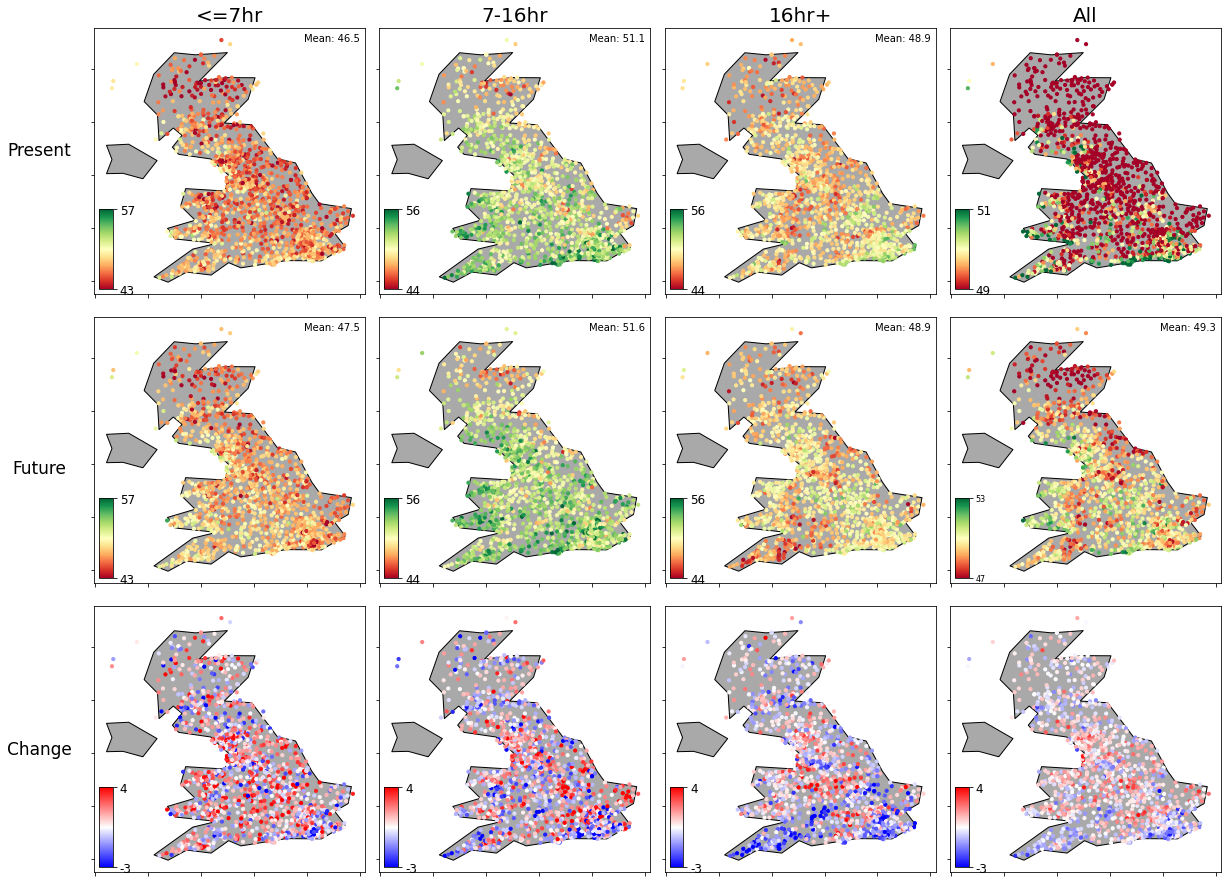

In [73]:
make_plot_durcats_individualcolorbars_simplecats(df_changes_all, df_changes_bydurationcat2, 'D50_mean', 'RdYlGn', D50_diffs_dict) 

39.16059081749023 53.44895075812785
42.85582002968119 57.14417997031881
43 57
41.65460263803327 59.3973028604955
41.128649888768884 58.871350111231116
41 59
43.7368670206301 56.61632672876319
43.56027014593346 56.43972985406654
44 56
39.24183803587018 55.26037211080092
41.99073296253463 58.00926703746537
42 58


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


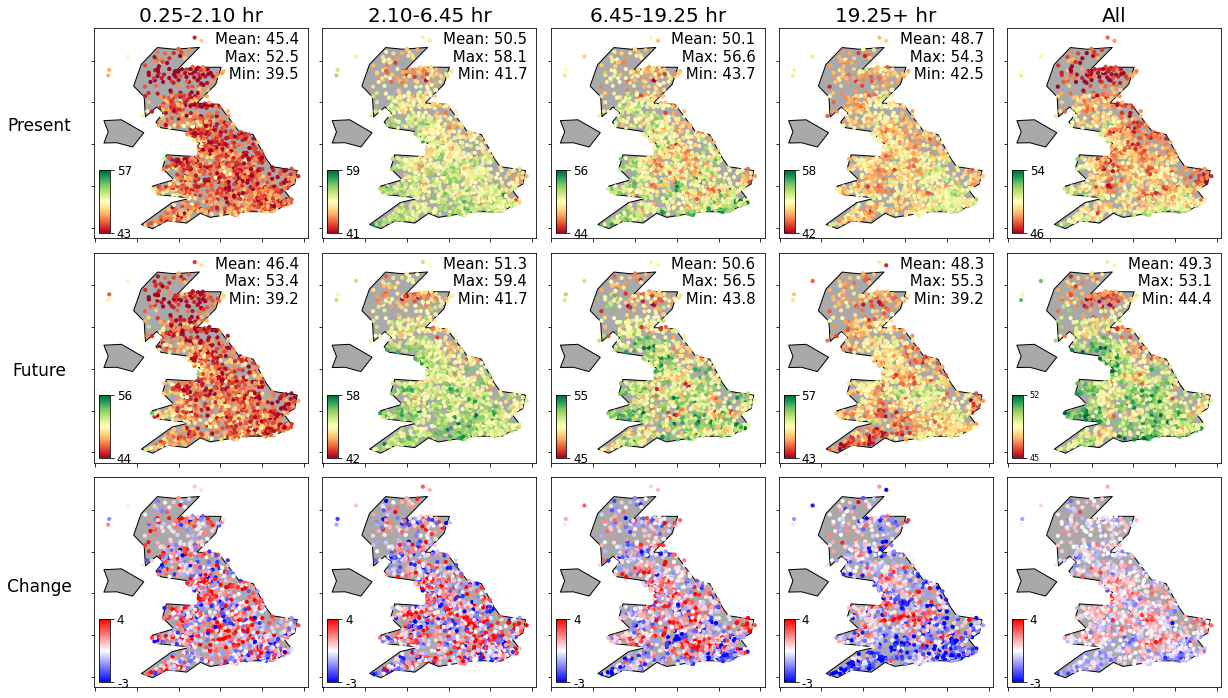

In [34]:
make_plot_durcats_individualcolorbars(df_changes_all, df_changes_bydurationcat, 'D50_mean', 'RdYlGn', D50_diffs_dict) 

7.38255033557047 28.205128205128204
39.58871106522113 60.41128893477887
40 60
11.11111111111111 37.410071942446045
36.85051958433253 63.14948041566747
37 63
11.214953271028037 39.81900452488688
35.69797437307058 64.30202562692942
36 64
8.403361344537815 35.25179856115108
36.57578139169337 63.42421860830663
37 63


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


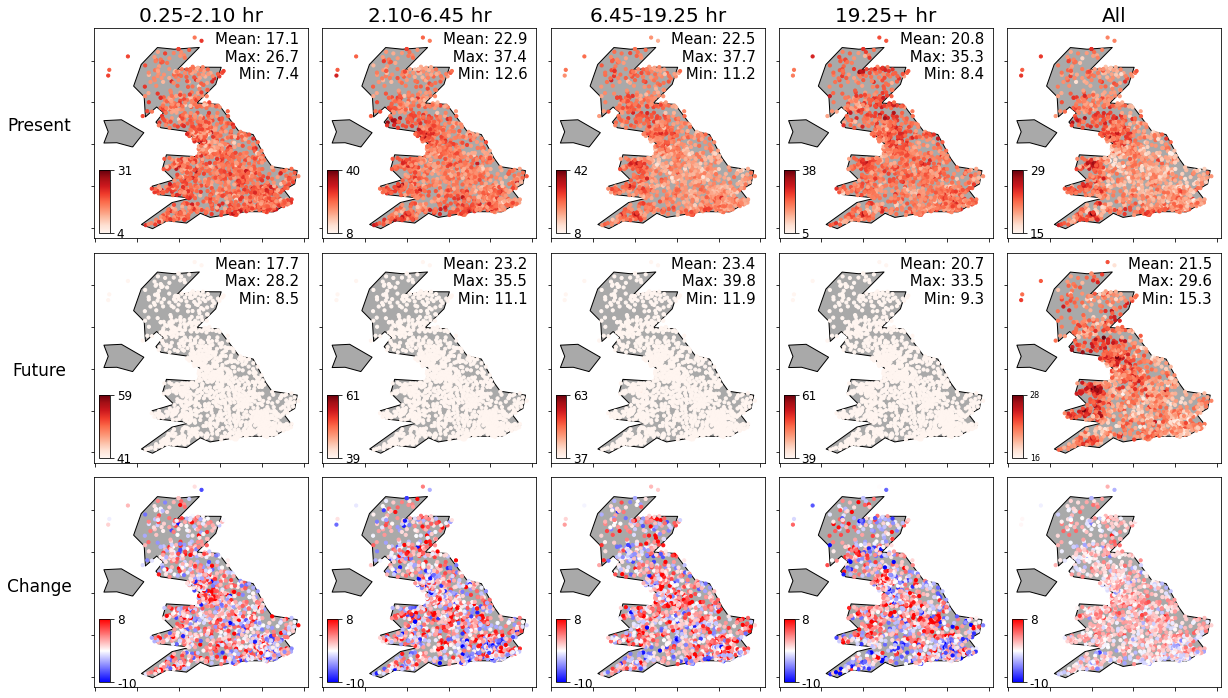

In [265]:
make_plot_durcats_individualcolorbars(df_changes_all, df_changes_bydurationcat, 'B1_percentage', 'Reds', D50_diffs_dict) 

3.389830508474576 26.923076923076923
38.23337679269883 61.76662320730117
38 62
6.0 37.77777777777778
34.111111111111114 65.88888888888889
34 66
2.666666666666667 31.674208144796378
35.496229260935145 64.50377073906486
35 65
2.312138728323699 33.77483443708609
34.2686521456188 65.7313478543812
34 66


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


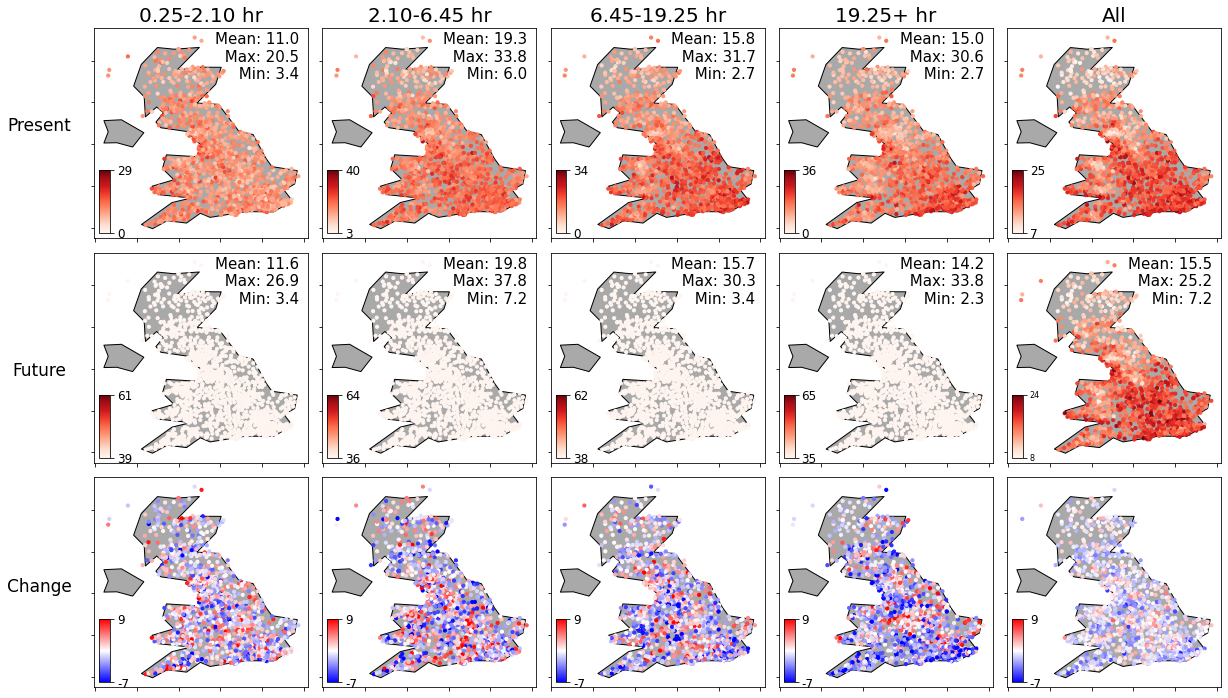

In [264]:
make_plot_durcats_individualcolorbars(df_changes_all, df_changes_bydurationcat, 'B2_percentage', 'Reds', D50_diffs_dict) 

9.248554913294797 32.8125
38.2180274566474 61.7819725433526
38 62
5.405405405405405 34.15841584158416
35.62349478191062 64.37650521808938
36 64
1.851851851851852 26.82926829268293
37.51129177958446 62.48870822041554
38 62
3.603603603603604 33.81294964028777
34.89532698165792 65.10467301834208
35 65


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


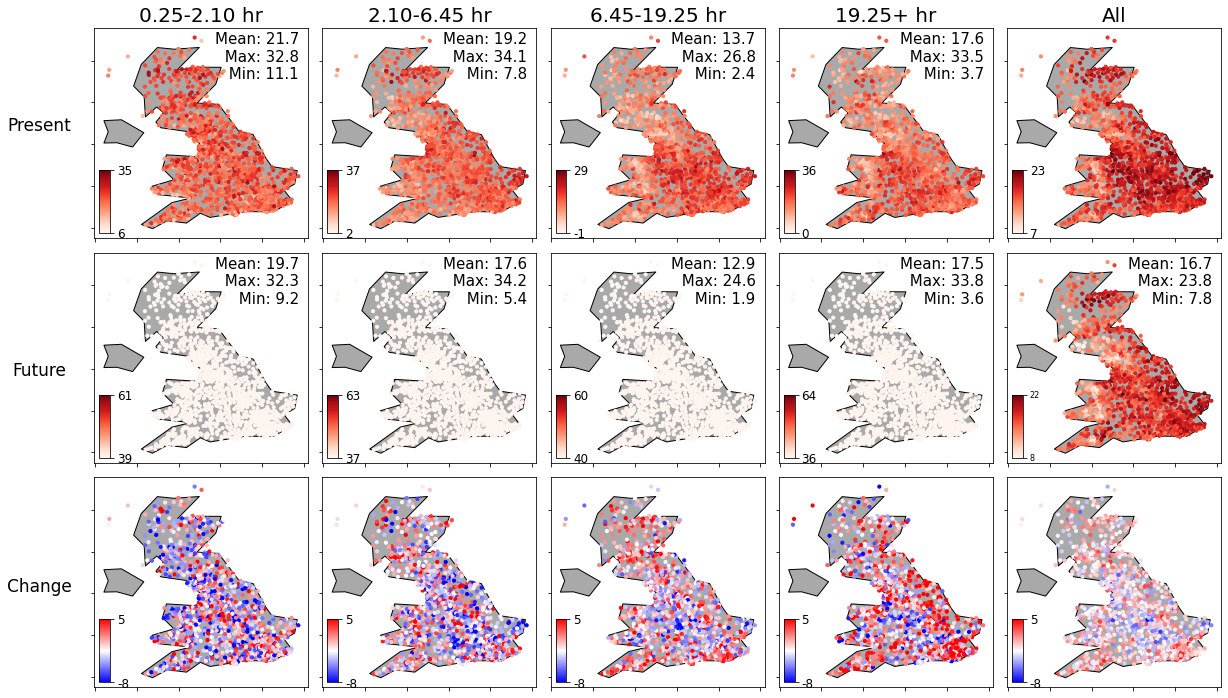

In [263]:
make_plot_durcats_individualcolorbars(df_changes_all, df_changes_bydurationcat, 'F2_percentage', 'Reds', D50_diffs_dict) 

## Distribution of values

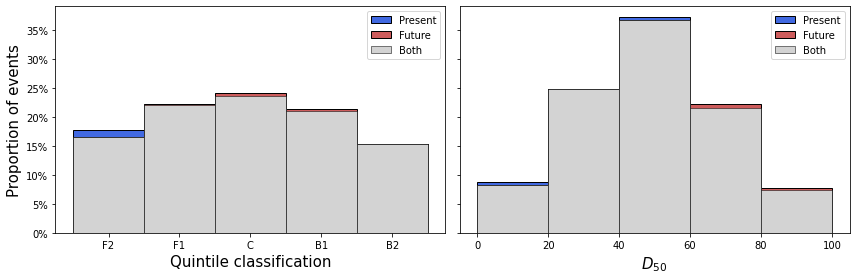

In [56]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

# Example bins
bins = 5

# Plot D50 histogram with overlap
plot_proportion_histogram_with_overlap(axs[1], present_all_events['D50_new'], future_all_events['D50_new'], bins=[0,20,40,60,80,100])
axs[1].set_xlabel("$D_{50}$", fontsize=15)
axs[0].set_ylabel('Proportion of events', fontsize=15)

# Repeat for max_quintile_molly
plot_proportion_histogram_with_overlap(axs[0], present_all_events['max_quintile_molly'], future_all_events['max_quintile_molly'], bins=bins)
axs[0].set_xlabel('Quintile classification', fontsize=15)

# Calculate bin edges and centers for x-tick positioning
counts, bin_edges = np.histogram(present_all_events['max_quintile_molly'], bins=5)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
axs[0].set_xticks(bin_centers)
axs[0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.tight_layout()
plt.show()

In [55]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def plot_proportion_histogram_with_overlap(ax, present, future, bins):
    # Calculate the histogram counts and bin edges for both distributions
    present_counts, present_bin_edges = np.histogram(present, bins=bins, density=True)
    future_counts, future_bin_edges = np.histogram(future, bins=bins, density=True)
    
    # Normalize counts to get proportions (i.e., counts / total count)
    present_proportions = present_counts / np.sum(present_counts)
    future_proportions = future_counts / np.sum(future_counts)
    
    # If no axes are passed, create a new plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the histograms as bar charts showing the proportions
    ax.bar(present_bin_edges[:-1], present_proportions, width=np.diff(present_bin_edges), color='royalblue', edgecolor='black', alpha=1, label='Present', align='edge')
    ax.bar(future_bin_edges[:-1], future_proportions, width=np.diff(future_bin_edges), color='indianred', edgecolor='black', alpha=1, label='Future', align='edge')
    
    # Prepare data for shading the overlap region
    overlap_props = np.minimum(present_proportions, future_proportions)
    # Shade the overlap area
    ax.bar(future_bin_edges[:-1], overlap_props, width=np.diff(future_bin_edges), color='lightgrey', edgecolor='black', alpha=1, label='Both', align='edge',
          linewidth=0.5)
    
    # Format the y-axis to show percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    
    # Show legend
    if axs[1]:
        ax.legend(loc='upper right')
    else:
        ax.legend().set_visible(False)

    # Display the plot
    plt.tight_layout()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

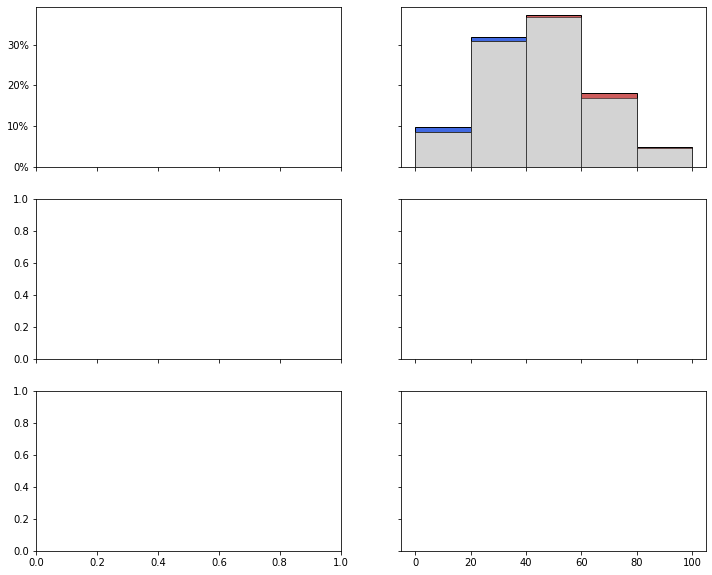

In [69]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 10), sharey='row', sharex='col')

# Example bins
bins = 5

for ax_num, duration in enumerate(['<4hr', '4-12hr','12hr+']):
    
    if duration =='All':
        this_duration_present = present_all_events
        this_duration_future = future_all_events
    else:
        this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
        this_duration_future = future_all_events[future_all_events["DurationRange_simple"] == duration]

    # Plot D50 histogram with overlap
    plot_proportion_histogram_with_overlap(axs[ax_num, 1], this_duration_present['D50_new'], this_duration_future['D50_new'], bins=[0,20,40,60,80,100])
    axs[2,1].set_xlabel("$D_{50}$", fontsize=15)
    axs[ax_num, 0].set_ylabel('Proportion of events', fontsize=15)

    # Repeat for max_quintile_molly
    plot_proportion_histogram_with_overlap(axs[ax_num, 0], this_duration_present['max_quintile_molly'], this_duration_future['max_quintile_molly'], bins=bins)
    axs[2,0].set_xlabel('Quintile classification', fontsize=15)

    # Create custom legend
    present_patch = mpatches.Patch(color='royalblue', label='Present')
    future_patch = mpatches.Patch(color='indianred', label='Future')
    overlap_patch = mpatches.Patch(color='grey', label='Overlap')
    fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.05])

    # Calculate bin edges and centers for x-tick positioning
    counts, bin_edges = np.histogram(this_duration_present['max_quintile_molly'], bins=5)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axs[ax_num,0].set_xticks(bin_centers)
    axs[ax_num,0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))    
plt.tight_layout()
plt.show()

In [46]:
# # Example usage with sample data
# fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12, 10), sharey=True, sharex='col')

# # Example bins
# bins = 5

# for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
  
    
#     if duration =='All':
#         this_duration_present = present_all_events
#         this_duration_future = future_all_events
#     else:
#         this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
#         this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]

#     # Plot D50 histogram with overlap
#     plot_quintile_hist_with_overlap_shading(axs[ax_num, 1], this_duration_present['D50_new'], this_duration_future['D50_new'], bins=bins)
#     axs[3,1].set_xlabel("$D_{50}$", fontsize=15)
#     axs[ax_num, 0].set_ylabel('Proportion of events', fontsize=15)

#     # Repeat for max_quintile_molly
#     plot_quintile_hist_with_overlap_shading(axs[ax_num, 0], this_duration_present['max_quintile_molly'], this_duration_future['max_quintile_molly'], bins=bins)
#     axs[3,0].set_xlabel('Quintile classification', fontsize=15)

#     # Create custom legend
#     present_patch = mpatches.Patch(color='royalblue', label='Present')
#     future_patch = mpatches.Patch(color='indianred', label='Future')
#     overlap_patch = mpatches.Patch(color='lightgrey', label='Overlap')
#     fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.05])

#     # Calculate bin edges and centers for x-tick positioning
#     counts, bin_edges = np.histogram(this_duration_present['max_quintile_molly'], bins=5)
#     bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#     axs[ax_num,0].set_xticks(bin_centers)
#     axs[ax_num,0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))    
# plt.tight_layout()
# plt.show()



## Loading categories

In [61]:
# # Define the duration categories
# durations =['<4hr', '4-12hr','12hr+']

# # Colors for the different histograms
# colors = ['blue', 'cyan', 'gray', 'red']

# # Create a figure and axis
# plt.figure(figsize=(10, 6))  # Adjust figure size

# # Loop through each duration category
# for ax_num, (duration, color) in enumerate(zip(durations, colors)):
#     # Filter the data for this duration
#     this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
#     print(this_duration_present['D50_new'].mean())
#     print(this_duration_present['D50_new'].median())
#     # Plot the histogram as a stepped line
#     plt.hist(
#         this_duration_present['D50_new'], 
#         bins=100, 
#         density=True, 
#         histtype='step', 
#         color=color, 
#         linewidth=1.5, 
#         label=duration
#     )

# # Add legend, labels, and grid
# plt.xlabel('D50_new', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.title('Stepped Histograms for Different Duration Categories', fontsize=14)
# plt.legend(title='Duration Categories')
# plt.grid(True, linestyle='--', alpha=0.5)

# # Show the plot
# plt.tight_layout()
# plt.show()


In [48]:
def categorize_d50(value):
    if 0 <= value < 20:
        return 'F2'
    elif 20 <= value < 40:
        return 'F1'
    elif 40 <= value < 60:
        return 'C'
    elif 60 <= value < 80:
        return 'B1'
    elif 80 <= value <= 100:
        return 'B2'
    else:
        return None  # For any values outside the specified range

# Apply the categorization function to create the new column
present_all_events['loading_profile_d50'] = present_all_events['D50_new'].apply(categorize_d50)
future_all_events['loading_profile_d50'] = future_all_events['D50_new'].apply(categorize_d50)

In [63]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

# for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
#     this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
#     create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'loading_profile_d50', 
#         quintile_cats, color_mapping,  duration)

# fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

# for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
#     this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
#     create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'loading_profile_d50', 
#         quintile_cats, color_mapping,  duration)
    

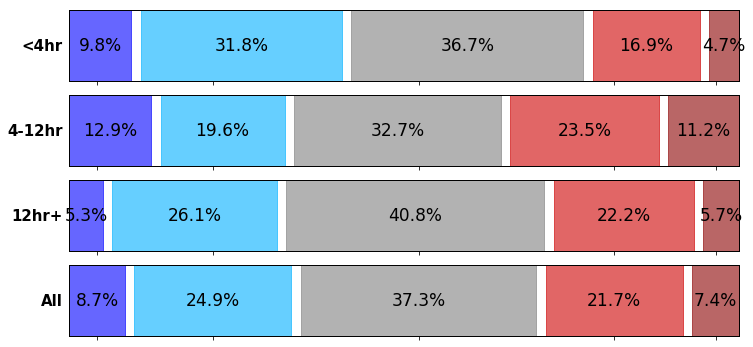

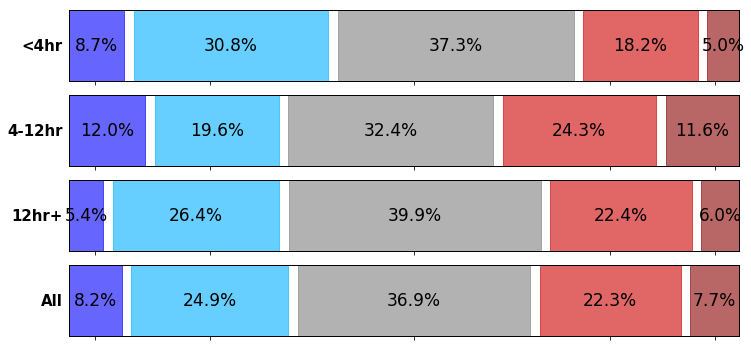

In [66]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['<4hr', '4-12hr','12hr+']):
    this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'loading_profile_d50', 
        quintile_cats, color_mapping,  duration)
create_single_variable_mosaic_plot_pctlabels(axs[3], present_all_events, 'loading_profile_d50', 
        quintile_cats, color_mapping,  'All') 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['<4hr', '4-12hr','12hr+']):
    this_duration_future = future_all_events[future_all_events["DurationRange_simple"] == duration]
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'loading_profile_d50', 
        quintile_cats, color_mapping,  duration)
create_single_variable_mosaic_plot_pctlabels(axs[3], future_all_events, 'loading_profile_d50', 
        quintile_cats, color_mapping,  'All')     

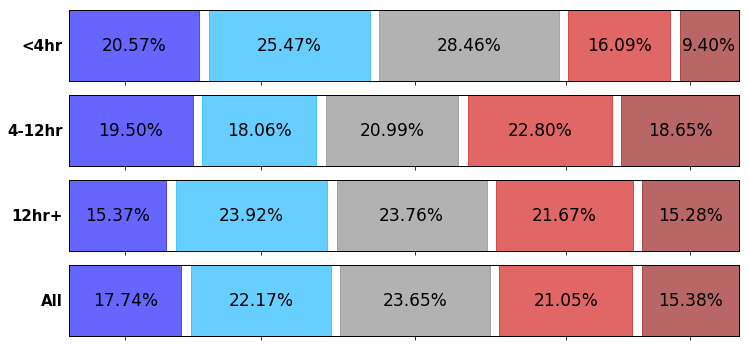

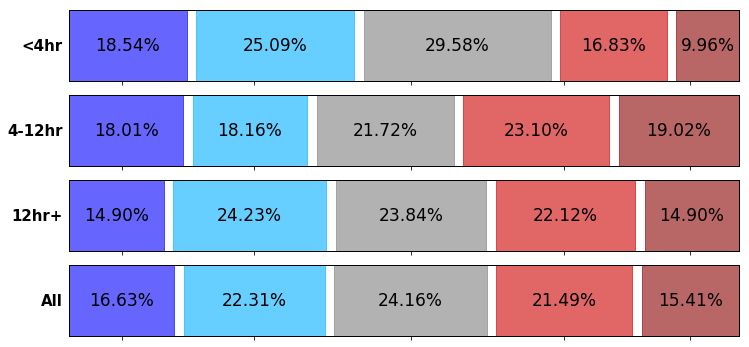

In [64]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['<4hr', '4-12hr','12hr+']):
    this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)
create_single_variable_mosaic_plot_pctlabels(axs[3], present_all_events, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  'All')    

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['<4hr', '4-12hr','12hr+']):
    this_duration_future = future_all_events[future_all_events["DurationRange_simple"] == duration]
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)
create_single_variable_mosaic_plot_pctlabels(axs[3], future_all_events, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  'All')        

In [60]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 6), sharey=True, sharex='col')

# for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
#     print(duration)
#     this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
#     print(len(this_duration_present)/len(present_all_events)*100, this_duration_present['D50_new'].mean())
#     create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  duration)
# create_single_variable_mosaic_plot_pctlabels(axs[4], present_all_events, 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  'All')    

# fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 6), sharey=True, sharex='col')

# for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
#     print(duration)
#     this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
#     print(len(this_duration_future)/len(future_all_events)*100, this_duration_future['D50_new'].mean())
#     create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  duration)
# create_single_variable_mosaic_plot_pctlabels(axs[4], future_all_events, 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  'All')        

### With seasonal split

In [ ]:
# # Define custom order for Loading_profile_molly and season
# loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
# season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# # Create a mapping for custom orders
# loading_mapping = {value: index for index, value in enumerate(loading_order)}
# season_mapping = {value: index for index, value in enumerate(season_order)}

# # Add new columns to the DataFrame for sorting
# present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
# present['Season_order'] = present['season'].map(season_mapping)

# # Sort the DataFrame by the new order columns
# present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# # Drop the temporary sorting columns
# present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
# fig, axs = plt.subplots(figsize=(12,8))
# plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)

## D50 vs Day of year

In [ ]:
# variable = 'D50_P90'
# variable = 'D50_P10'

In [59]:
def make_scatter_plot_durcats(df, duration, timeperiod, loadings, axes, ax_row):
    df["D_mean_present"] = df["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
    df["D_mean_future"] = df["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
    
    for ax_num, (loading, title) in enumerate(zip(loadings, loadings)):
        title = title if ax_row in[0,5] else ''
        
        if duration in ['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']:
            
            this_duration = df[df['sampling_duration'] == duration]
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                this_duration[f"D_mean_{timeperiod}"],
                this_duration[f"{loading}_percentage_{timeperiod}"],
                title
            )
        else:
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                df[f"D_mean_{timeperiod}"],
                df[f"{loading}_percentage_{timeperiod}"],
                title
            )


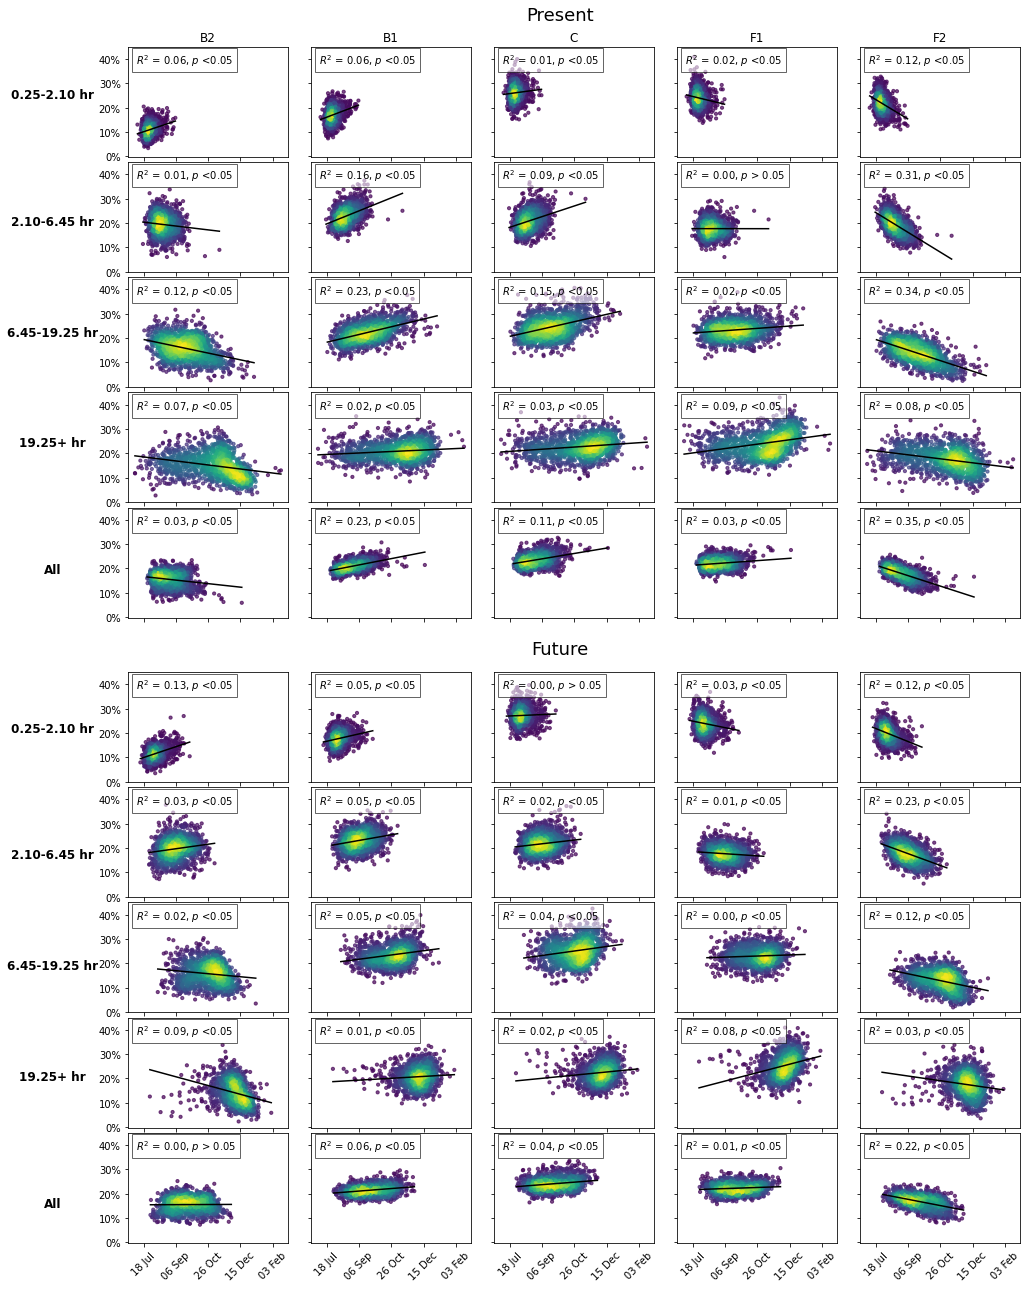

In [70]:
# Creating the axes layout
fig, axes = plt.subplots(
    11, 5, 
    figsize=(16, 22), 
    sharey='all', 
    sharex='all', 
    gridspec_kw={
        'hspace': 0.05, 
        'wspace': 0.14, 
        'height_ratios': [1, 1, 1, 1, 1, 0.4, 1, 1, 1, 1, 1]})

for ax_row in axes:
    for ax in ax_row:
        if ax is not None:  # Ensure the axis exists
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

loadings =['B2', 'B1', 'C', 'F1', 'F2']

# Call the function
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '0.25-2.10 hr', "present", loadings, axes, ax_row=0)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '2.10-6.45 hr', "present", loadings, axes, ax_row=1)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '6.45-19.25 hr', "present", loadings, axes, ax_row=2)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '19.25+ hr', "present", loadings, axes, ax_row=3)
make_scatter_plot_durcats(df_changes_all.copy(), 'All', "present", loadings, axes, ax_row=4)
fig.text(0.5, 0.9, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.06, 0.85, '0.25-2.10 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.77, '2.10-6.45 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.7, '6.45-19.25 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.63, '19.25+ hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.55, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')

for ax in axes[5]:
    ax.axis("off")

make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '0.25-2.10 hr', "future", loadings, axes, ax_row=6)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '2.10-6.45 hr', "future", loadings, axes, ax_row=7)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '6.45-19.25 hr', "future", loadings, axes, ax_row=8)
make_scatter_plot_durcats(df_changes_bydurationcat.copy(), '19.25+ hr', "future", loadings, axes, ax_row=9)
make_scatter_plot_durcats(df_changes_all.copy(), 'All', "future", loadings, axes, ax_row=10)
fig.text(0.5, 0.5, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.06, 0.45, '0.25-2.10 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.37, '2.10-6.45 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.3, '6.45-19.25 hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.23, '19.25+ hr', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.06, 0.15, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')


# After plotting, convert Julian day ticks to calendar dates
for ax in axes.flatten():
    if ax is not None:  # In case of unused subplots
        # Get the current axis limits
        x_min, x_max = ax.get_xlim()
        
        # Restrict ticks to the visible range
        ticks = ax.get_xticks()
        visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

        # Convert the visible ticks to date labels
        tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]
        # Apply the visible ticks and corresponding labels
        ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
        ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
        ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

plt.show()

## Plot contour plot of all events against the day of year they occurred

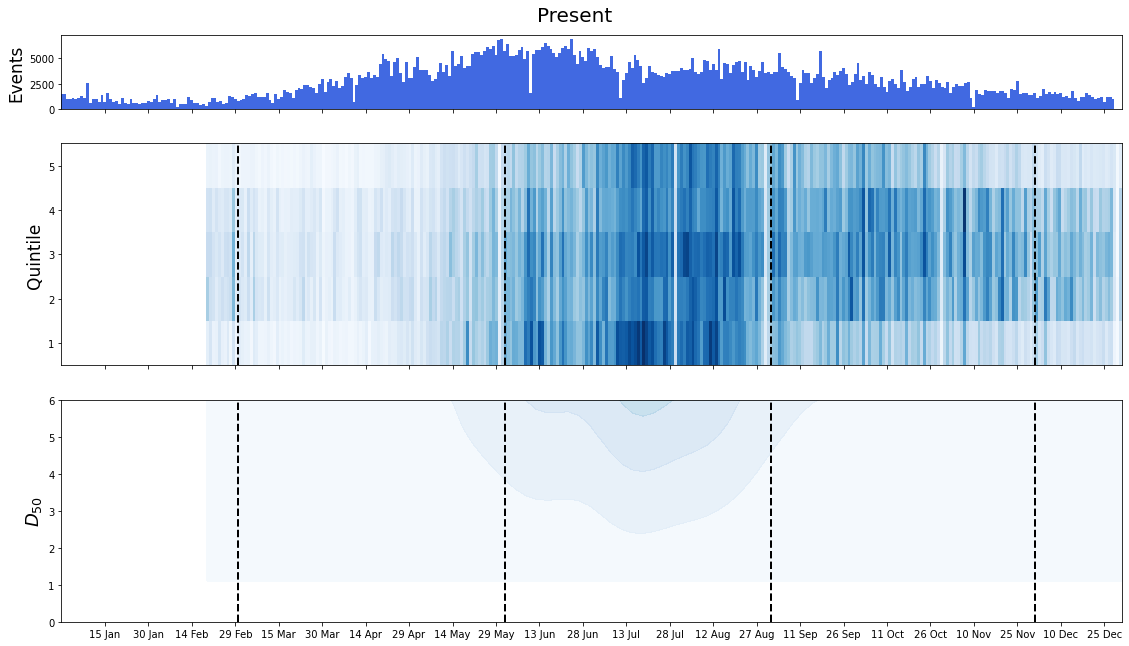

In [71]:
from datetime import datetime
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Present", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present_all_events

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='royalblue', linewidth=2, width=1)

# # Set labels
axs[0].set_ylabel('Events', fontsize=17);
axs[1].set_ylabel("Quintile", fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Blues'
)


plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Blues')

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

KeyError: 'D'

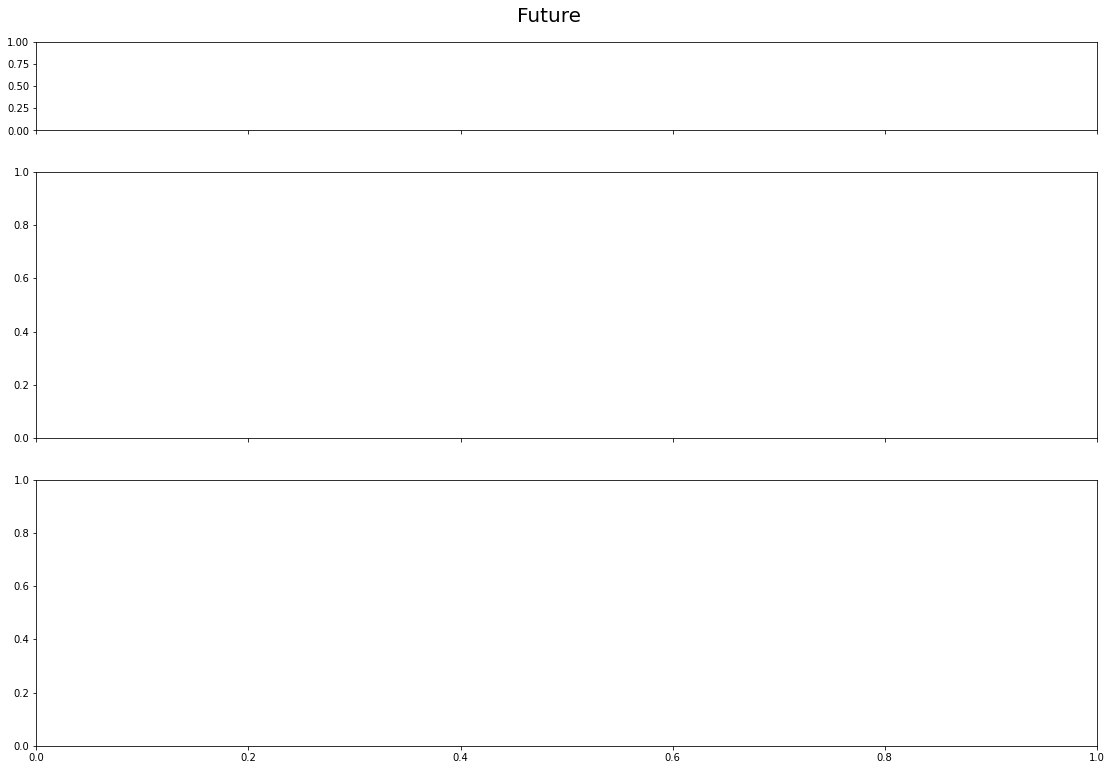

In [98]:
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

df = future_all_events

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Reds'
)

plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Reds' )

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
# After plotting your figure, you can add a vertical line to axs[1]
axs[0].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[0].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[0].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[0].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")


df = future

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Reds' )

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# After plotting your figure, you can add a vertical line to axs[1]
axs[0].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[0].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[0].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[0].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=50))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

## Another option: 

In [ ]:
def plot_contour_all_events(ax, data_x, data_y,cmap):
    # Create a grid for the contour plot
    x_grid = np.linspace(data_x.min(), data_x.max(), 100)
    y_grid = np.linspace(data_y.min(), data_y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde([data_x, data_y])
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Normalize the density values to be between 0 and 1
    Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

    # Create the contour plot with fixed color limits between 0 and 1
    contour = ax.contourf(X, Y, Z_normalized, levels=10, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
#     cbar = fig.colorbar(contour, ax=ax)
#     cbar.set_label('Density (normalized)')

    # Calculate R^2 and p-value
    slope, intercept, r_value, p_value, std_err = linregress(data_x, data_y)
    r_squared = r_value**2

    # Set labels and title
    # ax.set_xlabel('%' if ax in [axs[1, 0], axs[1, 1]] else '')
    ax.set_ylabel("$D_{50}$",fontsize=18)
    ax.set_xlim(0,366)
#     ax.set_ylim(0,6)

In [ ]:
def plot_2d_heatmap(ax, x, y, z, cmap="Blues", xlabel="Day of Year", ylabel="$D_{50}$", colorbar_label="Value"):
    """
    Plots a 2D heatmap on the given axes.

    Parameters:
        ax: Matplotlib Axes object where the heatmap will be plotted.
        x: 1D array-like. Data for the x-axis (e.g., day of the year).
        y: 1D array-like. Data for the y-axis (e.g., $D_{50}$ values).
        z: 1D array-like. Data for the color intensity (e.g., percentages or values to represent in heatmap).
        cmap: Colormap for the heatmap.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
        colorbar_label: Label for the colorbar.
    """
    # Create a grid for the heatmap
    heatmap_data, xedges, yedges = np.histogram2d(x, y, bins=[100, 100], weights=z, density=False)
    
    # Normalize the grid to remove empty spaces
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    cax = ax.imshow(
        heatmap_data.T,
        origin='lower',
        extent=extent,
        aspect='auto',
        cmap=cmap,
        interpolation='nearest',
    )
    
    # Add a colorbar
    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label(colorbar_label, fontsize=14)
    
    # Set axis labels
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)


In [ ]:
def make_contour_plot(df_changes_byduration, df_changes_all, variable):
    
    d_mean_pres = "D_mean_present"
    d_mean_fut = 'D_mean_future'
    
    durations =[1,6,24]

    df_changes_all_test =df_changes_all.copy()
    df_changes_byduration_test = df_changes_byduration.copy()
    
    df_changes_all_test[d_mean_pres] = df_changes_all_test[d_mean_pres].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all_test[d_mean_fut] = df_changes_all_test[d_mean_fut].apply(lambda x: x + 365 if x < 50 else x)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False ,sharex='all', gridspec_kw={'hspace': 0.2, 'wspace':0.14})
    # fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharey=False ,sharex=False, gridspec_kw={'hspace': 0.2, 'wspace':0.14})
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration[d_mean_pres] = this_duration[d_mean_pres].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[0, ax_num], this_duration[d_mean_pres],this_duration[f'{variable}_present'], "Day of year", f"{variable[:2]} %", f"{duration}hrs" )
    plot_contour(fig, axes[0, 3], df_changes_all_test[d_mean_pres],  df_changes_all_test[f'{variable}_present'],"Day of year", f"{variable[:2]} %", "All"  )
    fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
    for ax_num, (duration, title) in enumerate(zip(durations, titles)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration[d_mean_fut] = this_duration[d_mean_fut].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[1, ax_num], this_duration[d_mean_fut], this_duration[f'{variable}_future'], "Day of year", f"{variable[:2]} %" , f"{duration}hrs", 'Reds')   
    plot_contour(fig, axes[1, 3], df_changes_all_test[d_mean_fut], df_changes_all_test[f'{variable}_future'],  "Day of year", f"{variable[:2]} %" ,"All" , 'Reds')
    fig.text(0.04, 0.35, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   
    #fig.text(0.04, 0.5, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   
    
    
#     for ax_num, (duration, title) in enumerate(zip(durations, titles)):
#         this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
#         # axes[2,ax_num].scatter(this_duration['D_mean_diff'], this_duration[f'{variable}_diff'])
#         plot_contour(fig, axes[2, ax_num], this_duration['D_mean_diff'], this_duration[f'{variable}_diff'], "Day of year", f"{variable[:2]} %" , f"{duration}hrs", 'Greys')   
#     plot_contour(fig, axes[2, 3], df_changes_all_test['D_mean_diff'], df_changes_all_test[f'{variable}_diff'],  "Day of year", f"{variable[:2]} %" ,"All" , 'Greys')
#     fig.text(0.04, 0.23, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');       
    

    # After plotting, convert Julian day ticks to calendar dates
    for ax in axes.flatten()[:8]:
        if ax is not None:  # In case of unused subplots
            # Get the current axis limits
            x_min, x_max = ax.get_xlim()

            # Restrict ticks to the visible range
            ticks = ax.get_xticks()
            visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

            # Convert the visible ticks to date labels
            tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

            # Apply the visible ticks and corresponding labels
            ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
            ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
            ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [327]:
from matplotlib.colors import PowerNorm
def make_plot(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    print(np.unique(diffs_dict['All'],return_counts=True))
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())
        # low_lim = 45.5

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
        # high_lim=54.5

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Apply PowerNorm for non-linear scaling
    nonlinear_norm = PowerNorm(gamma=0.5, vmin=low_lim, vmax=high_lim)

    # Use this normalization for present and future plots
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)]
        scatter = plot_values_on_map(
            axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present,
            low_lim, high_lim, nonlinear_norm, cmap  # Pass non-linear norm
        )
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all, 'All', tbo_vals, 
                                 variable_present, low_lim, high_lim,nonlinear_norm,  cmap)
    
    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)]
        scatter = plot_values_on_map(
            axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future,
            low_lim, high_lim, nonlinear_norm, cmap  # Pass non-linear norm
        )
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[1, 3], df_changes_all, 'All', tbo_vals, 
                                 variable_future, low_lim, high_lim, nonlinear_norm,  cmap)    
    cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    low_lim_diff=-6
    high_lim_diff = -low_lim_diff

    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_diff']]
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        this_duration['sig'] =diffs_dict[duration] 
        scatter = plot_values_on_map_withsig(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff',
                                             low_lim_diff, high_lim_diff, 'bwr')
    
    # Plot 'All' differences
    scatter = plot_values_on_map_withsig(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals,
                                         variable_diff, low_lim_diff, high_lim_diff, 'bwr')    
    
    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.05)
    
    plt.tight_layout()    

def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, norm, cmap='viridis'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=10, marker='o',
         norm=norm
    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return scatter
    
def make_plot_durcats(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
    nonlinear_norm = PowerNorm(gamma=0.5, vmin=low_lim, vmax=high_lim)
    
    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Using the adjusted `low_lim` and `high_lim`
    for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_present]]        
        scatter = plot_values_on_map(
            axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present,
            low_lim, high_lim, nonlinear_norm, cmap )
        
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals,
                                 variable_present, low_lim, high_lim, nonlinear_norm, cmap)

    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.1)
    
    plt.tight_layout()        
    
#     #################################################
#     # Plot Future Data for Each Duration
#     #################################################
#     for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
#         this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_future]]
#         plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)

#     # Plot 'All' future values
#     scatter = plot_values_on_map(axes[1, 3], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
#     cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
#     cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
#     cbar.ax.tick_params(labelsize=16) 
    
#     if 'percentage' in variable:
#         cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
#     #################################################
#     # Plot Difference Data if Available
#     #################################################
#     variable_diff = f'{variable}_diff'

#     # Calculate and apply color limits centered around 0 for the difference
#     low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
#                         abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
#     # low_lim_diff=-6
#     high_lim_diff = -low_lim_diff

#     for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
#         this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num',  f'{variable}_diff']]
        
#         this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
#         scatter = plot_values_on_map(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff',
#                                              low_lim_diff, high_lim_diff, 'bwr')
    
#     # Plot 'All' differences
#     scatter = plot_values_on_map(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals,
#                                          variable_diff, low_lim_diff, high_lim_diff, 'bwr')    
    
#     # Create the colorbar in this new axis
#     cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
#     cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
#     cbar.ax.tick_params(labelsize=16) 
#     if 'percentage' in variable:
#         cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.1)
    
    plt.tight_layout()    

In [377]:
from matplotlib.colors import TwoSlopeNorm, PowerNorm

def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, norm, cmap='viridis'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=10, marker='o',
        norm=norm  # Apply normalization
    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return scatter


def make_plot_durcats(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits and Center at 50
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())
        print(low_lim)

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                       df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())
        print(high_lim)
    
    high_lim=58
    low_lim=42
    
    # Normalization centered at 50, with sharp color differentiation around [45, 55]
    custom_norm = TwoSlopeNorm(vmin=low_lim, vcenter=50, vmax=high_lim)
    # custom_norm = PowerNorm(gamma=0.8, vmin=low_lim, vmax=high_lim)
    
    #################################################
    # Plot Present Data for Each Duration
    #################################################
    for i, duration in enumerate(['<4hr', '4-12hr', '12hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_present]]        
        scatter = plot_values_on_map(
            axes[0, i], this_duration, f'{duration}', tbo_vals, variable_present,
            low_lim, high_lim, custom_norm, cmap
        )
        
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals,
                                 variable_present, low_lim, high_lim, custom_norm, cmap)

    #################################################
    # Add Colorbar for Present Data
    #################################################
    cbar_ax = fig.add_axes([1.005, 0.7, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16)

    # Add labels at the top and bottom of the colorbar
    cbar.set_ticks([low_lim, high_lim])  # Only show top and bottom ticks
    cbar.ax.set_yticklabels([f'{low_lim:.1f}', f'{high_lim:.1f}'], fontsize=16)
    
    #################################################
    # Add Labels
    #################################################
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    #################################################
    # Adjust Layout
    #################################################
    plt.subplots_adjust(hspace=-0.1)
    plt.tight_layout() 


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


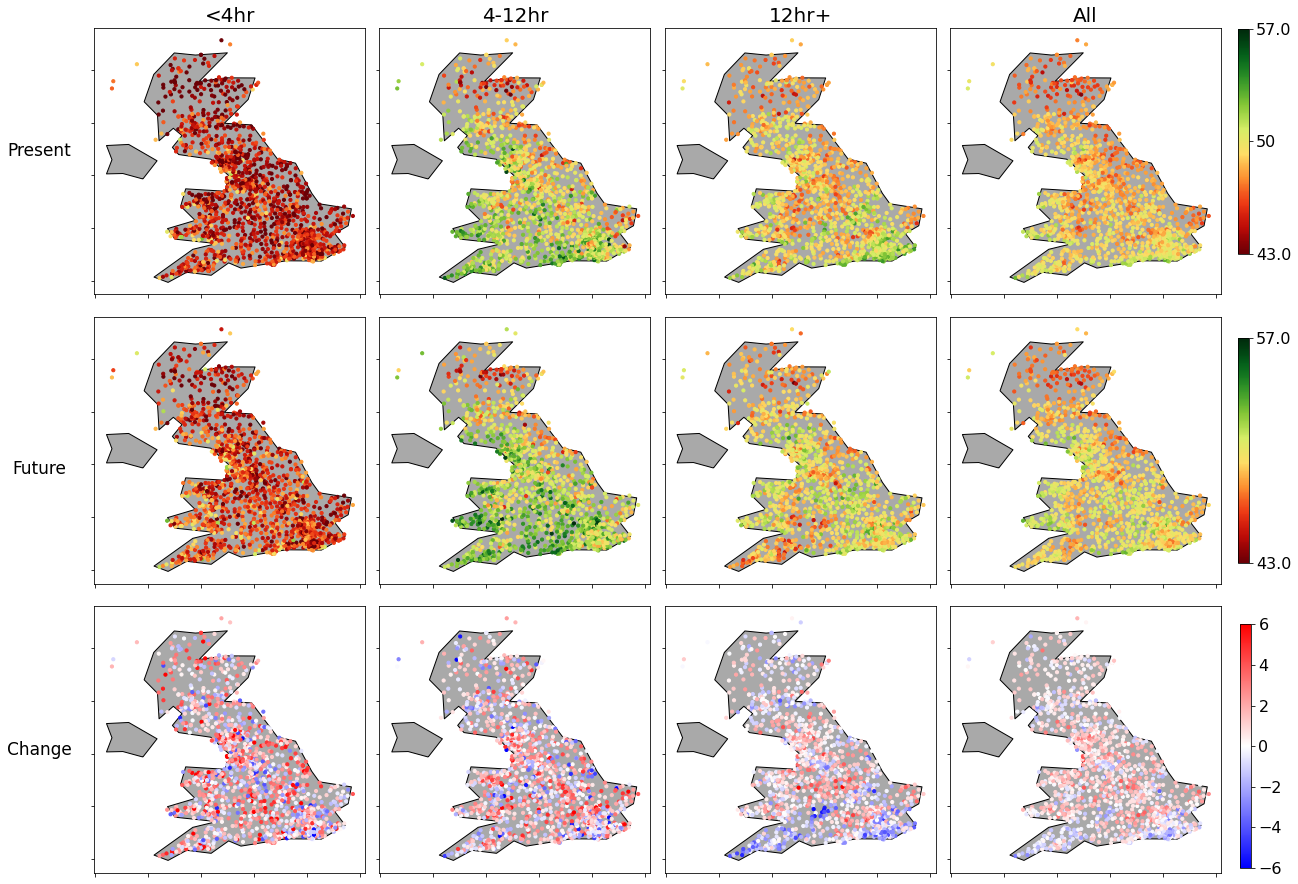

In [449]:
cmap = create_custom_colormap()

def modify_colormap(cmap, gamma=2.0):
    """
    Modify the colormap to emphasize the center by applying a power law transformation.
    
    Args:
        cmap: The original colormap
        gamma: The degree of emphasis on the center (higher gamma = more emphasis in the middle)
    
    Returns:
        A new colormap emphasizing the center
    """
    # Get the original colormap with 256 discrete colors
    colors = cmap(np.linspace(0, 1, 256))
    
    # Apply a power law transformation to enhance the center
    # For gamma > 1, the mid part of the colormap gets more variation
    # For gamma < 1, the extremes get more variation
    new_colors = np.copy(colors)
    
    # Apply a power transformation to the r, g, b channels separately
    for i in range(3):  # Apply to each RGB channel
        new_colors[:, i] = np.power(colors[:, i], gamma)

    # Create a new colormap from the modified colors
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_cmap", new_colors)
    
    return new_cmap

cmap = modify_colormap(cmap)
make_plot_durcats(df_changes_all, df_changes_bydurationcat2, 'D50_mean', cmap, D50_diffs_dict) 

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define a function to create a customized colormap with emphasis on the middle
def create_custom_colormap():
    # Create a colormap using a diverging color palette (like "coolwarm")
    cmap = cm.get_cmap('RdYlGn')

    # Adjust the colormap to emphasize the center (modify the range around the midpoint)
    new_colors = cmap(np.linspace(0, 1, 10))

    # Define the modified colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", new_colors)

    return new_cmap

# Function to plot values on map with the customized color map
def plot_values_on_map_norm(ax, data, title, tbo_vals, value_column, low_lim, high_lim, norm, cmap='coolwarm'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=10, marker='o',
         norm=norm
    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])  # No axis labels
    ax.set_yticklabels([])  # No axis labels
    
    return scatter


def plot_values_on_map(ax, data, title, tbo_vals, value_column, low_lim, high_lim, cmap='coolwarm'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=10, marker='o',
         vmin=low_lim,vmax=high_lim    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])  # No axis labels
    ax.set_yticklabels([])  # No axis labels
    
    return scatter

# Function to generate the plot
def make_plot_durcats(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())
        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
    
    # Use a `TwoSlopeNorm` to focus on the middle (50 in this case)
    high_lim=57
    low_lim = 43
    
    norm = TwoSlopeNorm(vmin=low_lim, vcenter=50, vmax=high_lim)

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_present]]        
        scatter = plot_values_on_map_norm(
            axes[0, i], this_duration, f'{duration}', tbo_vals, variable_present,
            low_lim, high_lim, norm, cmap )
        
    # Plot 'All' present values
    scatter = plot_values_on_map_norm(axes[0, 3], df_changes_all[['gauge_num', variable_present]], 'All', tbo_vals,
                                 variable_present, low_lim, high_lim, norm, cmap)

    cbar_ax = fig.add_axes([1.005, 0.71, 0.01, 0.24])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical', norm=norm)
    cbar.ax.tick_params(labelsize=16) 
    
    # Set ticks at the bottom, middle, and top
    cbar.set_ticks([low_lim, 50, high_lim])

    # Set custom labels for the ticks
    cbar.ax.set_yticklabels([f'{low_lim:.1f}', '50', f'{high_lim:.1f}'], fontsize=16)

    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num', variable_future]]
        scatter = plot_values_on_map_norm(
            axes[1, i], this_duration, f'{duration}', tbo_vals, variable_future,
            low_lim, high_lim, norm, cmap )
        
    # Plot 'All' future values
    scatter = plot_values_on_map_norm(axes[1, 3], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals,
                                 variable_future, low_lim, high_lim, norm, cmap)
    
    #################################################
    # Add Colorbar for Future Data
    #################################################
    cbar_ax = fig.add_axes([1.005, 0.38, 0.01, 0.24])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16)

    # Add labels at the top and bottom of the colorbar
    cbar.set_ticks([low_lim, high_lim])  # Only show top and bottom ticks
    cbar.ax.set_yticklabels([f'{low_lim:.1f}', f'{high_lim:.1f}'], fontsize=16)        
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    low_lim_diff=-6
    high_lim_diff = -low_lim_diff

    for i, duration in enumerate(['<4hr', '4-12hr','12hr+']):
        this_duration = df_changes_byduration[df_changes_byduration["sampling_duration"] == duration][['gauge_num',  f'{variable}_diff']]
        
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        scatter = plot_values_on_map(axes[2, i], this_duration, f'{duration}', tbo_vals, f'{variable}_diff',
                                             low_lim_diff, high_lim_diff, 'bwr')
    
    # Plot 'All' differences
    scatter = plot_values_on_map(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals,
                                         variable_diff, low_lim_diff, high_lim_diff, 'bwr')    
    
    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.1)
    
    plt.tight_layout()    